In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = pd.read_csv('ratings.csv')
dataset['movieId'].nunique()

9066

In [43]:
dataset.head(4)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185


In [3]:
sparsity = dataset.shape[0]/(dataset['movieId'].nunique() * dataset['userId'].nunique())

In [4]:
print(sparsity)

0.016439141608663475


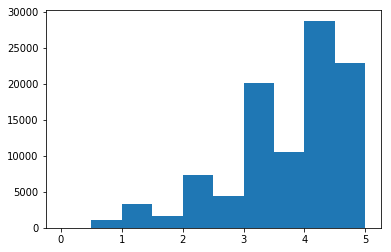

In [5]:
plt.hist(dataset['rating'],bins=np.arange(0, 5 + 0.5, 0.5))
plt.show()

In [6]:
from collections import Counter
movie_ids = dataset['movieId']
#Counter(movie_ids)

In [7]:
movie_ratings_dict = dict(Counter(movie_ids))

In [8]:
plt.plot(range(0,len(movie_ratings_dict.keys())), sorted(movie_ratings_dict.values(),reverse=True))

In [9]:
user_ids = dataset['userId']

In [10]:
user_ratings_dict = dict(Counter(user_ids))

In [11]:
plt.plot(range(0,len(user_ratings_dict.keys())), sorted(user_ratings_dict.values(),reverse=True))

In [12]:
sum(sorted(user_ratings_dict.values(),reverse=True)[:100])

55141

In [13]:
id_var = (dataset[['movieId','rating']].groupby('movieId',as_index=False)).var().fillna(0)


In [14]:
id_var

,movieId,rating
0,1,0.919646
1,2,0.775657
2,3,1.322764
3,4,0.881410
4,5,0.899675
5,6,0.690441
6,7,1.216437
7,8,2.700000
8,9,0.660526
9,10,0.592603


In [15]:
id_var_dict = dict(zip(list(id_var['movieId']), id_var['rating']))


In [16]:
print(id_var_dict)

{1: 0.91964550212303686, 2: 0.77565685064362566, 3: 1.322764465225015, 4: 0.8814102564102565, 5: 0.89967532467532441, 6: 0.6904406273338316, 7: 1.216436865021771, 8: 2.6999999999999997, 9: 0.66052631578947374, 10: 0.59260262837013944, 11: 0.80024841915085809, 12: 1.2295751633986927, 13: 0.9598214285714286, 14: 0.6059139784946237, 15: 0.81363636363636349, 16: 0.77034352142110707, 17: 0.86186730506155962, 18: 1.4034615384615383, 19: 1.1661490683229809, 20: 1.6025641025641029, 21: 1.0225643896976477, 22: 0.93118776671408232, 23: 0.89610389610389607, 24: 1.3086007130124773, 25: 1.1680693069306929, 26: 0.79999999999999993, 27: 0.47619047619047628, 28: 0.65441176470588247, 29: 0.65320512820512822, 30: 0.91388888888888886, 31: 0.70513937282229966, 32: 0.69924123495552137, 34: 1.1529233314947596, 35: 0.67272727272727262, 36: 0.65867718446601931, 37: 2.0, 38: 2.0, 39: 0.92184873949579793, 40: 0.64166666666666639, 41: 0.91996047430830041, 42: 0.5, 43: 0.77840909090909105, 44: 0.9126955903271694,

In [17]:
var_list = list(dataset[['movieId','rating']].groupby('movieId').var()['rating'])

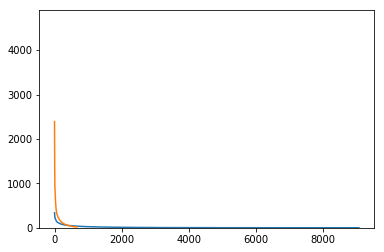

In [18]:
plt.hist(np.nan_to_num(var_list),bins=np.arange(min(var_list), max(var_list), 0.5))
plt.show()


In [19]:
print('hello')

hello


In [20]:
popular_movieids = [x[0] for x in movie_ratings_dict.items() if x[1]>2]
unpopular_movieids = [x[0] for x in movie_ratings_dict.items() if x[1]<=2]
high_variance_movieids = [x[0] for x in movie_ratings_dict.items() if x[1]>=5]
high_variance_movieids = [x for x in high_variance_movieids if id_var_dict[x]>=2 ]

In [21]:
len(popular_movieids)
len(unpopular_movieids)
len(high_variance_movieids)

123

In [22]:
popular_movie_dataset = dataset.loc[dataset['movieId'].isin(popular_movieids)]
unpopular_movie_dataset = dataset.loc[dataset['movieId'].isin(unpopular_movieids)]
highvar_movie_dataset = dataset.loc[dataset['movieId'].isin(high_variance_movieids)]

In [23]:
len(popular_movie_dataset)

94537

### Question 10

#### Takes 15-20 min

In [25]:
from surprise import SVD

In [56]:
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise import Dataset
from surprise import accuracy
from surprise import Reader


In [59]:
sim_options = {'name': 'pearson_baseline'}
kf = KFold(n_splits=10)
reader = Reader(rating_scale=(1, 5))
data_ = Dataset.load_from_df(dataset[['userId','movieId','rating']], reader)
mae_d={}
rmse_d={}
for neigh in range(2,101,2):
    print('Neighbors ',neigh)
    knn_model = KNNWithMeans(min_k=neigh, sim_options= sim_options)
    rmse_list=[]
    mae_list =[]
    for trainset, testset in kf.split(data_):
        knn_model.fit(trainset)
        predictions = knn_model.test(testset)
        rmse_list.append(accuracy.rmse(predictions))
        mae_list.append(accuracy.mae(predictions))
    rmse_d[neigh]=sum(rmse_list)/len(rmse_list)
    mae_d[neigh]=sum(mae_list)/len(mae_list)
    print('Mean rmse',sum(rmse_list)/len(rmse_list))
    print('Mean mae',sum(mae_list)/len(mae_list))
    

Neighbors  2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9160
MAE:  0.6907
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8856
MAE:  0.6759
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9064
MAE:  0.6908
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9047
MAE:  0.6881
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9193
MAE:  0.6987
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9105
MAE:  0.6911
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9097

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9144
MAE:  0.6998
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9280
MAE:  0.7022
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9142
MAE:  0.6905
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9273
MAE:  0.7076
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9086
MAE:  0.6910
Mean rmse 0.915707008733
Mean mae 0.696029054508
Neighbors  14
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9008
MAE:  0.6859
Estimating biases using als...
Computing the pearson_baseline similarity matrix

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9197
MAE:  0.7016
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9205
MAE:  0.7047
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9483
MAE:  0.7204
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9362
MAE:  0.7104
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9299
MAE:  0.7102
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9347
MAE:  0.7091
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9323
MAE:  0.7097

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9373
MAE:  0.7190
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9417
MAE:  0.7164
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9386
MAE:  0.7192
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9478
MAE:  0.7248
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9322
MAE:  0.7166
Mean rmse 0.937506989226
Mean mae 0.717503695216
Neighbors  36
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9392
MAE:  0.7224
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity m

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9739
MAE:  0.7566
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9695
MAE:  0.7539
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9766
MAE:  0.7623
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9606
MAE:  0.7493
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9727
MAE:  0.7578
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9613
MAE:  0.7488
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9763
MAE:  0.7600

Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9579
MAE:  0.7480
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9803
MAE:  0.7619
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9635
MAE:  0.7487
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9704
MAE:  0.7588
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9738
MAE:  0.7584
Mean rmse 0.969976941665
Mean mae 0.75556738125
Neighbors  58
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9743
MAE:  0.7590
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity ma

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9657
MAE:  0.7564
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9645
MAE:  0.7514
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9722
MAE:  0.7577
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9766
MAE:  0.7569
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9583
MAE:  0.7487
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9737
MAE:  0.7599
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9685
MAE:  0.7556

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9773
MAE:  0.7620
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9731
MAE:  0.7606
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9536
MAE:  0.7429
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9694
MAE:  0.7562
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9716
MAE:  0.7571
Mean rmse 0.969989601709
Mean mae 0.755697976095
Neighbors  80
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9627
MAE:  0.7526
Estimating biases using als...
Computing the pearson_baseline similarity matrix

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9526
MAE:  0.7448
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9696
MAE:  0.7571
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9747
MAE:  0.7618
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9821
MAE:  0.7624
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9813
MAE:  0.7636
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9511
MAE:  0.7393
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9827
MAE:  0.7674

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9779
MAE:  0.7621
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9692
MAE:  0.7517
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9728
MAE:  0.7588
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9734
MAE:  0.7555
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9654
MAE:  0.7536
Mean rmse 0.969894962804
Mean mae 0.755521395832


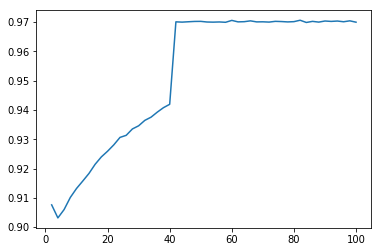

In [60]:
plt.plot(rmse_d.keys(),rmse_d.values())
plt.show()

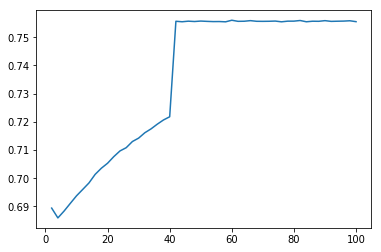

In [61]:
plt.plot(mae_d.keys(),mae_d.values())
plt.show()